In [1]:
from datetime import date, timedelta
import gzip
import numpy as np
import geopandas as gpd
import pandas as pd
import json
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import pycountry
import folium 
from folium import plugins

In [2]:
dia = (date.today() - timedelta(1))
dia = dia.strftime('%d/%m/%y')

In [3]:
dia

'15/04/21'

In [ ]:
# cleaning the enviroment
def my_reset(*varnames):
    """
    varnames are what you want to keep
    """
    globals_ = globals()
    to_save = {v: globals_[v] for v in varnames}
    to_save['my_reset'] = my_reset  # lets keep this function by default
    del globals_
    get_ipython().magic("reset")
    globals().update(to_save)

In [ ]:
def get_grouped_by_date_states_data(estado, df):
    """Returns a new data frame with the time series from the states selected
    grouped by date, confirmed cases and deaths cases"""
    filtro = (df['state'] == estado)
    data = df.loc[filtro]
    na = data['city'].isnull()
    drop = list(data.loc[na].index)
    data = data.copy()
    data.drop(drop, inplace=True)
    return data.groupby(['date'])[['last_available_confirmed', 
                                                  'last_available_deaths']].agg('sum').reset_index()

In [ ]:
def states_data(df, state, place_type):
    """Returns a new data frame with data from the brazilian states selected"""
    temp = df.copy()
    idx_to_drop = temp.index[temp['city'] == 'Importados/Indefinidos'].to_list()
    temp.drop(idx_to_drop, inplace=True)
    f = (df_IO['state'] == state) & (df_IO['place_type'] == place_type)
    temp = temp.loc[f].reset_index(drop=True)
    func = lambda x: 0 if x < 0 else x
    temp['new_confirmed'] = temp['new_confirmed'].apply(func)
    return temp

In [ ]:
def world_map(suffix):
    # downloading the world data from https://github.com/CSSEGISandData
    path = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{suffix}_global.csv'
    df = pd.read_csv(path)
    df['Country/Region'] = df['Country/Region'].replace('US', 'United States of America')
    
    # getting the iso symbols for the countries
    iso = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    iso.index = iso['name']
    # indexing the iso df with the country column of the covid data
    iso = iso.reindex(df['Country/Region'])
    iso['iso_a3'] = iso['iso_a3'].fillna('NaN')
    # creating the iso column iith the iso a3 symbols in the covid data frame
    df['iso_a3'] = iso['iso_a3'].reset_index(drop=True)
    
    date_cols = list(df.columns[4:-1])
    countries = np.array([[i] * len(date_cols) for i in df['iso_a3']]).flatten()
    dates = date_cols * len(df['Country/Region'])
    values = np.array([list(i) for i in df[date_cols].iloc]).flatten()
    data = pd.DataFrame({'country':countries, 'date':dates, suffix:values})

    fig = px.choropleth(data, locations='country', color=suffix, animation_frame='date')
    fig.show()

In [ ]:
# func = lambda x: 0 if x < 0 else x

In [ ]:
!ls Data

In [ ]:
df_IO = pd.read_csv('Data/caso_full.csv.gz', compression='gzip')

In [ ]:
df_IO[(df_IO['new_confirmed'] < 0 )]

In [ ]:
sc_covid = states_data(df_IO, 'SC', 'city')

In [ ]:
sc_covid.drop(['estimated_population_2019',
               'is_last',
               'is_repeated',
               'last_available_confirmed_per_100k_inhabitants',
               'last_available_date',
               'order_for_place',
               'place_type',
               'state'],
              axis=1,
              inplace=True)

In [ ]:
sc_covid.head(5)

In [ ]:
sc_covid.rename(columns={'city': 'cidade', 
                'city_ibge_code': 'ibge_code',
                'date': 'data',
                'epidemiological_week': 'semana_epi', 
                 'last_available_confirmed': 'confirmados', 
                 'last_available_death_rate': 'mortalidade',
                 'last_available_deaths': 'obitos',
                 'new_confirmed': 'novos_casos',
                 'new_deaths': 'novos_obitos'},
                inplace=True)

In [ ]:
(sc_covid['cidade'] == 'Importados/Indefinidos').sum()

In [ ]:
sc_covid

In [ ]:
sc_covid[(sc_covid['novos_casos'] < 0 )]

In [ ]:
# sc_covid[['novos_casos']].idxmin()

In [ ]:
y = np.array(sc_covid['novos_casos'])

In [ ]:
y.max(), y.min()

In [ ]:
x =  np.array(sc_covid['data'])

In [ ]:
ax = plt.axes()

plt.plot(x, y)

ax.xaxis.set_major_locator(plt.MaxNLocator())
plt.xticks(rotation=90)
#plt.grid(color='w', linestyle='solid')
ax.grid()
plt.show()

In [ ]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=x, y=y,
                    mode='markers',
                    name='markers'))

fig.show()

In [ ]:
fig = px.line(sc_covid, x=x, y=y, hover_name="novos_casos")
fig.show()

In [ ]:
# with open('/home/paulo/Documents/Projetos/UFSC_Covid/Data/brazil_geo.json') as file:
#     br = json.load(file)



# fig = go.Figure(go.Choroplethmapbox(geojson=br,locations=sc_covid.cidade,z=sc_covid.confirmados,
#                                     colorscale='Cividis',zmin=0,zmax=17,
#                                     marker_opacity=0.5, marker_line_width=0))
# fig.update_layout(mapbox_style="carto-positron",
#                   mapbox_zoom=3, mapbox_center = {"lat": -14.235004, "lon": -51.92528})
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

In [ ]:
fig = px.line(sc_covid, x=sc_covid['data'], y=sc_covid['novos_casos'], hover_name="novos_casos")
fig.update_layout(title=f'Novos casos diários comfirmados de Covid-19 em Santa Catarina ( {dia})',
                   xaxis_title='Data',
                   yaxis_title='Novos casos diarios')
fig.show()

In [ ]:
# confirmed = pd.read_csv('https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv')

In [ ]:
# discrad the province with data
# confirmed = confirmed[confirmed['Province/State'].isna() == True]

In [ ]:
# the index of the data frame now is the country names
# confirmed.index = confirmed['Country/Region'].to_list()

In [ ]:
# confirmed = confirmed.drop(['Province/State', 'Lat', 'Long', 'Country/Region'], axis = 1)

In [ ]:
# confirmed = confirmed.drop(list(confirmed.columns[0:30]), axis = 1)

In [4]:
def world_data(case_type='confirmed'):
    case = pd.read_csv(f'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_{case_type}_global.csv&filename=time_series_covid19_{case_type}_global.csv')
    case = case[case['Province/State'].isna() == True]
    case.index = case['Country/Region'].to_list()
    case = case.drop(['Province/State', 'Lat', 'Long', 'Country/Region'], axis = 1)
    return case

In [5]:
confirmed = world_data(case_type='confirmed')

In [9]:
deaths = world_data(case_type='deaths')

In [11]:
# Return a new Index with elements of index not in other.
# This is the set difference of two Index objects.
deaths.loc['Sweden'].diff().index

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '4/6/21', '4/7/21', '4/8/21', '4/9/21', '4/10/21', '4/11/21', '4/12/21',
       '4/13/21', '4/14/21', '4/15/21'],
      dtype='object', length=450)

In [13]:
# Calculates the difference of a Dataframe element compared 
# with another element in the Dataframe (default is element in previous row).
deaths.loc['Sweden'].diff()

1/22/20     NaN
1/23/20     0.0
1/24/20     0.0
1/25/20     0.0
1/26/20     0.0
           ... 
4/11/21     0.0
4/12/21     0.0
4/13/21    39.0
4/14/21    60.0
4/15/21    41.0
Name: Sweden, Length: 450, dtype: float64

In [10]:
deaths_sweden_df = pd.DataFrame({'Date': deaths.loc['Sweden'].diff().index, 
                                 'DeathPerDay': list(deaths.loc['Sweden'].diff())})

In [12]:
deaths_sweden_df = deaths_sweden_df[deaths_sweden_df['DeathPerDay'] >= 2]
deaths_sweden_df

Date  DeathPerDay
52   3/14/20          2.0
53   3/15/20          2.0
55   3/17/20          6.0
56   3/18/20          7.0
57   3/19/20          9.0
..       ...          ...
442   4/8/21         17.0
443   4/9/21         26.0
447  4/13/21         39.0
448  4/14/21         60.0
449  4/15/21         41.0

[230 rows x 2 columns]

In [17]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20, 15))
# sns.barplot(x='Date', y='DeathPerDay', data = deaths_sweden_df, color = 'blue')
# plt.ylabel('NUMBER OF DEATHS PER DAY', fontsize = 22)
# plt.xlabel('DATE', fontsize = 22)
# plt.xticks(rotation=90)
# plt.title('CSSE DATA SWEDEN: NUMBER OF DEATHS PER DAY', fontsize = 22)
# plt.show()

In [16]:
fig = px.bar(deaths_sweden_df, x='Date', y='DeathPerDay')
fig.show()

Let us have a look at the number of deaths after 23d of March

In [19]:
deaths_weekday_sweden = deaths.loc['Sweden'].diff()[['3/24/20', '3/25/20', '3/26/20', '3/27/20', 
                                                     '3/30/20', '3/31/20', '4/1/20', '4/2/20', '4/3/20', 
                                                     '4/6/20', '4/7/20', '4/8/20', '4/9/20', '4/10/20', 
                                                     '4/14/20', '4/15/20', '4/16/20']]
deaths_weekday_sweden

3/24/20     22.0
3/25/20     31.0
3/26/20     32.0
3/27/20     35.0
3/30/20     48.0
3/31/20     53.0
4/1/20      70.0
4/2/20      80.0
4/3/20      70.0
4/6/20      76.0
4/7/20     114.0
4/8/20      96.0
4/9/20     106.0
4/10/20     77.0
4/14/20    114.0
4/15/20    170.0
4/16/20    130.0
Name: Sweden, dtype: float64

In [23]:
deaths.shape, deaths.shape

((189, 450), (189, 450))

In [25]:
deaths2cases = (deaths + 1) / (confirmed + 1)
deaths2cases = deaths2cases.drop(list(deaths2cases.columns[0:25]), axis = 1)
deaths2cases.head()

2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  \
Afghanistan      1.0      1.0      1.0      1.0      1.0      1.0      1.0   
Albania          1.0      1.0      1.0      1.0      1.0      1.0      1.0   
Algeria          1.0      1.0      1.0      1.0      1.0      1.0      1.0   
Andorra          1.0      1.0      1.0      1.0      1.0      1.0      1.0   
Angola           1.0      1.0      1.0      1.0      1.0      1.0      1.0   

             2/23/20  2/24/20  2/25/20  ...    4/6/21    4/7/21    4/8/21  \
Afghanistan      1.0      0.5      0.5  ...  0.044259  0.044185  0.044201   
Albania          1.0      1.0      1.0  ...  0.017993  0.018020  0.018022   
Algeria          1.0      1.0      0.5  ...  0.026408  0.026414  0.026414   
Andorra          1.0      1.0      1.0  ...  0.009571  0.009706  0.009750   
Angola           1.0      1.0      1.0  ...  0.023945  0.023815  0.023800   

               4/9/21   4/10/21   4/11/21   4/12/21   4/13/21   4/14/21  \
Afghanistan  0.044230  0.044133  0.044121  0.044198  0.044104  0.044058   
Albania      0.018037  0.018033  0.018054  0.018067  0.018073  0.018083   
Algeria      0.026418  0.026415  0.026418  0.026423  0.026414  0.026409   
Andorra      0.009713  0.009682  0.009645  0.009696  0.009671  0.009650   
Angola       0.023663  0.023616  0.023617  0.023567  0.023420  0.023404   

              4/15/21  
Afghanistan  0.044043  
Albania      0.018090  
Algeria      0.026397  
Andorra      0.009650  
Angola       0.023297  

[5 rows x 425 columns]

In [47]:
eur_countries = ['Austria', 
                 'Belgium', 
                 'Bulgaria', 
                 'Croatia', 
                 'Cyprus', 
                 'Czechia', 
                 'Denmark', 
                 'Estonia', 
                 'Finland', 
                 'France', 
                 'Germany', 
                 'Greece', 
                 'Hungary', 
                 'Ireland',
                 'Israel',
                 'Italy', 
                 'Latvia', 
                 'Lithuania', 
                 'Luxembourg', 
                 'Malta', 
                 'Netherlands', 
                 'Poland', 
                 'Portugal', 
                 'Romania', 
                 'Slovakia', 
                 'Slovenia', 
                 'Spain', 
                 'Sweden', 
                 'United Kingdom', 
                 'Russia', 
                 'Turkey', 
                 'Serbia', 
                 'Switzerland']
deaths2cases_europe = deaths2cases.loc[eur_countries]
deaths2cases_europe

2/16/20   2/17/20   2/18/20   2/19/20   2/20/20   2/21/20  \
Austria         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Belgium         0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
Bulgaria        1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Croatia         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Cyprus          1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Czechia         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Denmark         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Estonia         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Finland         0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
France          0.153846  0.153846  0.153846  0.153846  0.153846  0.153846   
Germany         0.058824  0.058824  0.058824  0.058824  0.058824  0.058824   
Greece          1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Hungary         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Ireland         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Israel          1.000000  1.000000  1.000000  1.000000  1.000000  0.500000   
Italy           0.250000  0.250000  0.250000  0.250000  0.250000  0.095238   
Latvia          1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Lithuania       1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Luxembourg      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Malta           1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Netherlands     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Poland          1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Portugal        1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Romania         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Slovakia        1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Slovenia        1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Spain           0.333333  0.333333  0.333333  0.333333  0.333333  0.333333   
Sweden          0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
United Kingdom  0.052632  0.050000  0.050000  0.047619  0.043478  0.041667   
Russia          0.333333  0.333333  0.333333  0.333333  0.333333  0.333333   
Turkey          1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Serbia          1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
Switzerland     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

                 2/22/20   2/23/20   2/24/20   2/25/20  ...    4/6/21  \
Austria         1.000000  1.000000  1.000000  0.333333  ...  0.016909   
Belgium         0.500000  0.500000  0.500000  0.500000  ...  0.025698   
Bulgaria        1.000000  1.000000  1.000000  1.000000  ...  0.038634   
Croatia         1.000000  1.000000  1.000000  0.500000  ...  0.021766   
Cyprus          1.000000  1.000000  1.000000  1.000000  ...  0.005426   
Czechia         1.000000  1.000000  1.000000  1.000000  ...  0.017470   
Denmark         1.000000  1.000000  1.000000  1.000000  ...  0.010383   
Estonia         1.000000  1.000000  1.000000  1.000000  ...  0.008719   
Finland         0.500000  0.500000  0.500000  0.500000  ...  0.010753   
France          0.153846  0.153846  0.153846  0.133333  ...  0.020110   
Germany         0.058824  0.058824  0.058824  0.055556  ...  0.026546   
Greece          1.000000  1.000000  1.000000  1.000000  ...  0.030305   
Hungary         1.000000  1.000000  1.000000  1.000000  ...  0.031947   
Ireland         1.000000  1.000000  1.000000  1.000000  ...  0.019790   
Israel          0.500000  0.500000  0.500000  0.500000  ...  0.007495   
Italy           0.047619  0.025641  0.034783  0.034056  ...  0.030311   
Latvia          1.000000  1.000000  1.000000  1.000000  ...  0.018539   
Lithuania       1.000000  1.000000  1.000000  1.00

In [48]:
deaths_europe = deaths.iloc[:,-1].loc[eur_countries].sort_values(ascending=False)
deaths_europe

United Kingdom    127191
Italy             115937
Russia            102667
France             99427
Germany            79672
Spain              76882
Poland             60612
Turkey             35031
Czechia            28229
Romania            25800
Hungary            24521
Belgium            23636
Portugal           16933
Netherlands        16861
Bulgaria           14979
Sweden             13761
Slovakia           10877
Switzerland        10498
Austria             9813
Greece              9239
Croatia             6442
Israel              6315
Serbia              5881
Ireland             4820
Slovenia            4142
Lithuania           3730
Denmark             2449
Latvia              2030
Estonia             1064
Finland              885
Luxembourg           785
Malta                403
Cyprus               283
Name: 4/15/21, dtype: int64

In [49]:
deaths2cases.iloc[:,-1]

Afghanistan           0.044043
Albania               0.018090
Algeria               0.026397
Andorra               0.009650
Angola                0.023297
                        ...   
Vietnam               0.013048
West Bank and Gaza    0.010629
Yemen                 0.194062
Zambia                0.013597
Zimbabwe              0.041445
Name: 4/15/21, Length: 189, dtype: float64

In [50]:
deaths.iloc[:,-1]

Afghanistan           2533
Albania               2335
Algeria               3144
Andorra                121
Angola                 557
                      ... 
Vietnam                 35
West Bank and Gaza    2937
Yemen                 1097
Zambia                1230
Zimbabwe              1550
Name: 4/15/21, Length: 189, dtype: int64

In [51]:
mortality_rate = deaths2cases.iloc[:,-1].sort_values(ascending=False)
mortality_rate[0:65]

Micronesia               0.500000
MS Zaandam               0.300000
Samoa                    0.250000
Vanuatu                  0.250000
Marshall Islands         0.200000
                           ...   
Moldova                  0.022500
Burma                    0.022488
Chile                    0.022481
Argentina                0.022413
Saint Kitts and Nevis    0.022222
Name: 4/15/21, Length: 65, dtype: float64

In [34]:
mortality_rate_europe = deaths2cases_europe.iloc[:,-1].sort_values(ascending=True)
mortality_rate_europe

Cyprus            0.005265
Turkey            0.008572
Serbia            0.008982
Estonia           0.009165
Denmark           0.010194
Finland           0.010642
Luxembourg        0.012177
Netherlands       0.012235
Malta             0.013542
Sweden            0.015420
Lithuania         0.016189
Switzerland       0.016660
Austria           0.016722
Czechia           0.017712
Slovenia          0.018016
Latvia            0.018509
France            0.019307
Ireland           0.019888
Portugal          0.020418
Croatia           0.021412
Russia            0.022211
Spain             0.022635
Poland            0.022940
Belgium           0.025164
Romania           0.025288
Germany           0.025616
United Kingdom    0.029033
Slovakia          0.029089
Greece            0.029999
Italy             0.030301
Hungary           0.033273
Bulgaria          0.039137
Name: 4/15/21, dtype: float64

In [52]:
pop_size_europe_dict = {'Italy': 60.36e+6, 
                        'Spain': 46.94e+6, 
                        'France': 66.99e+6, 
                        'United Kingdom': 66.65e+6, 
                        'Belgium': 11.46e+6, 
                        'Germany': 83.02e+6, 
                        'Netherlands': 17.28e+6, 
                        'Turkey': 82e+6, 
                        'Switzerland': 8.57e+6, 
                        'Sweden': 10.23e+6, 
                        'Portugal': 10.28e+6, 
                        'Ireland': 6.57e+6, 
                        'Austria': 8.859e+6, 
                        'Romania': 19.41e+6, 
                        'Denmark': 5.806e+6, 
                        'Poland': 37.97e+6, 
                        'Russia': 144.5e+6, 
                        'Czechia': 10.65e+6, 
                        'Hungary': 9.773e+6, 
                        'Greece': 10.72e+6, 
                        'Serbia': 6.982e+6, 
                        'Finland': 5.518e+6, 
                        'Luxembourg': 0.6e+6, 
                        'Slovenia': 2.081e+6, 
                        'Bulgaria': 7e+6, 
                        'Estonia': 1.328e+6, 
                        'Croatia': 4e+6, 
                        'Lithuania': 2.794e+6, 
                        'Cyprus': 1.17e+6, 
                        'Slovakia': 5.45e+6, 
                        'Latvia': 1.92e+6, 
                        'Malta': 0.493e+6, 
                        'Israel': 8.88e+6}

In [53]:
pop_size_europe_df = pd.DataFrame(pop_size_europe_dict.items(), columns=['Country', 'PopSize'])
pop_size_europe_df

Country      PopSize
0            Italy   60360000.0
1            Spain   46940000.0
2           France   66990000.0
3   United Kingdom   66650000.0
4          Belgium   11460000.0
5          Germany   83020000.0
6      Netherlands   17280000.0
7           Turkey   82000000.0
8      Switzerland    8570000.0
9           Sweden   10230000.0
10        Portugal   10280000.0
11         Ireland    6570000.0
12         Austria    8859000.0
13         Romania   19410000.0
14         Denmark    5806000.0
15          Poland   37970000.0
16          Russia  144500000.0
17         Czechia   10650000.0
18         Hungary    9773000.0
19          Greece   10720000.0
20          Serbia    6982000.0
21         Finland    5518000.0
22      Luxembourg     600000.0
23        Slovenia    2081000.0
24        Bulgaria    7000000.0
25         Estonia    1328000.0
26         Croatia    4000000.0
27       Lithuania    2794000.0
28          Cyprus    1170000.0
29        Slovakia    5450000.0
30          Latvia    1920000.0
31           Malta     493000.0
32          Israel    8880000.0

In [54]:
deaths_europe_df = pd.DataFrame({'Country': deaths_europe.index, 
                                         'deaths': list(deaths_europe)})
deaths_europe_df

Country  deaths
0   United Kingdom  127191
1            Italy  115937
2           Russia  102667
3           France   99427
4          Germany   79672
5            Spain   76882
6           Poland   60612
7           Turkey   35031
8          Czechia   28229
9          Romania   25800
10         Hungary   24521
11         Belgium   23636
12        Portugal   16933
13     Netherlands   16861
14        Bulgaria   14979
15          Sweden   13761
16        Slovakia   10877
17     Switzerland   10498
18         Austria    9813
19          Greece    9239
20         Croatia    6442
21          Israel    6315
22          Serbia    5881
23         Ireland    4820
24        Slovenia    4142
25       Lithuania    3730
26         Denmark    2449
27          Latvia    2030
28         Estonia    1064
29         Finland     885
30      Luxembourg     785
31           Malta     403
32          Cyprus     283

In [55]:
death_popsize_df = pd.merge(pop_size_europe_df, deaths_europe_df, on = 'Country')
death_popsize_df['deaths2popsize'] = (death_popsize_df['deaths'] / death_popsize_df['PopSize']) * 1e+6
death_popsize_df = death_popsize_df.sort_values(by=['deaths2popsize'], ascending=False)
death_popsize_df

Country      PopSize  deaths  deaths2popsize
17         Czechia   10650000.0   28229     2650.610329
18         Hungary    9773000.0   24521     2509.055561
24        Bulgaria    7000000.0   14979     2139.857143
4          Belgium   11460000.0   23636     2062.478185
29        Slovakia    5450000.0   10877     1995.779817
23        Slovenia    2081000.0    4142     1990.389236
0            Italy   60360000.0  115937     1920.758781
3   United Kingdom   66650000.0  127191     1908.342086
10        Portugal   10280000.0   16933     1647.178988
1            Spain   46940000.0   76882     1637.878142
26         Croatia    4000000.0    6442     1610.500000
15          Poland   37970000.0   60612     1596.312879
2           France   66990000.0   99427     1484.206598
9           Sweden   10230000.0   13761     1345.161290
27       Lithuania    2794000.0    3730     1335.003579
13         Romania   19410000.0   25800     1329.211747
22      Luxembourg     600000.0     785     1308.333333
8      Switzerland    8570000.0   10498     1224.970828
12         Austria    8859000.0    9813     1107.687098
30          Latvia    1920000.0    2030     1057.291667
6      Netherlands   17280000.0   16861      975.752315
5          Germany   83020000.0   79672      959.672368
19          Greece   10720000.0    9239      861.847015
20          Serbia    6982000.0    5881      842.308794
31           Malta     493000.0     403      817.444219
25         Estonia    1328000.0    1064      801.204819
11         Ireland    6570000.0    4820      733.637747
32          Israel    8880000.0    6315      711.148649
16          Russia  144500000.0  102667      710.498270
7           Turkey   82000000.0   35031      427.207317
14         Denmark    5806000.0    2449      421.805029
28          Cyprus    1170000.0     283      241.880342
21         Finland    5518000.0     885      160.384197

In [56]:
death_popsize = death_popsize_df['deaths2popsize']
death_popsize.index = death_popsize_df['Country']
death_popsize = death_popsize.sort_values(ascending=True)
death_popsize

Country
Finland            160.384197
Cyprus             241.880342
Denmark            421.805029
Turkey             427.207317
Russia             710.498270
Israel             711.148649
Ireland            733.637747
Estonia            801.204819
Malta              817.444219
Serbia             842.308794
Greece             861.847015
Germany            959.672368
Netherlands        975.752315
Latvia            1057.291667
Austria           1107.687098
Switzerland       1224.970828
Luxembourg        1308.333333
Romania           1329.211747
Lithuania         1335.003579
Sweden            1345.161290
France            1484.206598
Poland            1596.312879
Croatia           1610.500000
Spain             1637.878142
Portugal          1647.178988
United Kingdom    1908.342086
Italy             1920.758781
Slovenia          1990.389236
Slovakia          1995.779817
Belgium           2062.478185
Bulgaria          2139.857143
Hungary           2509.055561
Czechia           2650.610329
Na

In [57]:
deaths2cases.loc['Sweden']

2/16/20    0.500000
2/17/20    0.500000
2/18/20    0.500000
2/19/20    0.500000
2/20/20    0.500000
             ...   
4/11/21    0.015888
4/12/21    0.015888
4/13/21    0.015586
4/14/21    0.015497
4/15/21    0.015420
Name: Sweden, Length: 425, dtype: float64

In [62]:
mortality_rate_europe.values

array([0.00526462, 0.00857166, 0.00898192, 0.00916515, 0.01019427,
       0.01064213, 0.01217661, 0.01223528, 0.0135416 , 0.01541994,
       0.01618915, 0.01665992, 0.01672221, 0.01771185, 0.01801555,
       0.01850873, 0.01930724, 0.01988837, 0.02041818, 0.02141236,
       0.02221066, 0.02263471, 0.02293998, 0.02516422, 0.02528761,
       0.02561624, 0.02903279, 0.02908937, 0.02999932, 0.03030142,
       0.03327349, 0.03913659])

In [58]:
mortality_rate_europe

Cyprus            0.005265
Turkey            0.008572
Serbia            0.008982
Estonia           0.009165
Denmark           0.010194
Finland           0.010642
Luxembourg        0.012177
Netherlands       0.012235
Malta             0.013542
Sweden            0.015420
Lithuania         0.016189
Switzerland       0.016660
Austria           0.016722
Czechia           0.017712
Slovenia          0.018016
Latvia            0.018509
France            0.019307
Ireland           0.019888
Portugal          0.020418
Croatia           0.021412
Russia            0.022211
Spain             0.022635
Poland            0.022940
Belgium           0.025164
Romania           0.025288
Germany           0.025616
United Kingdom    0.029033
Slovakia          0.029089
Greece            0.029999
Italy             0.030301
Hungary           0.033273
Bulgaria          0.039137
Name: 4/15/21, dtype: float64

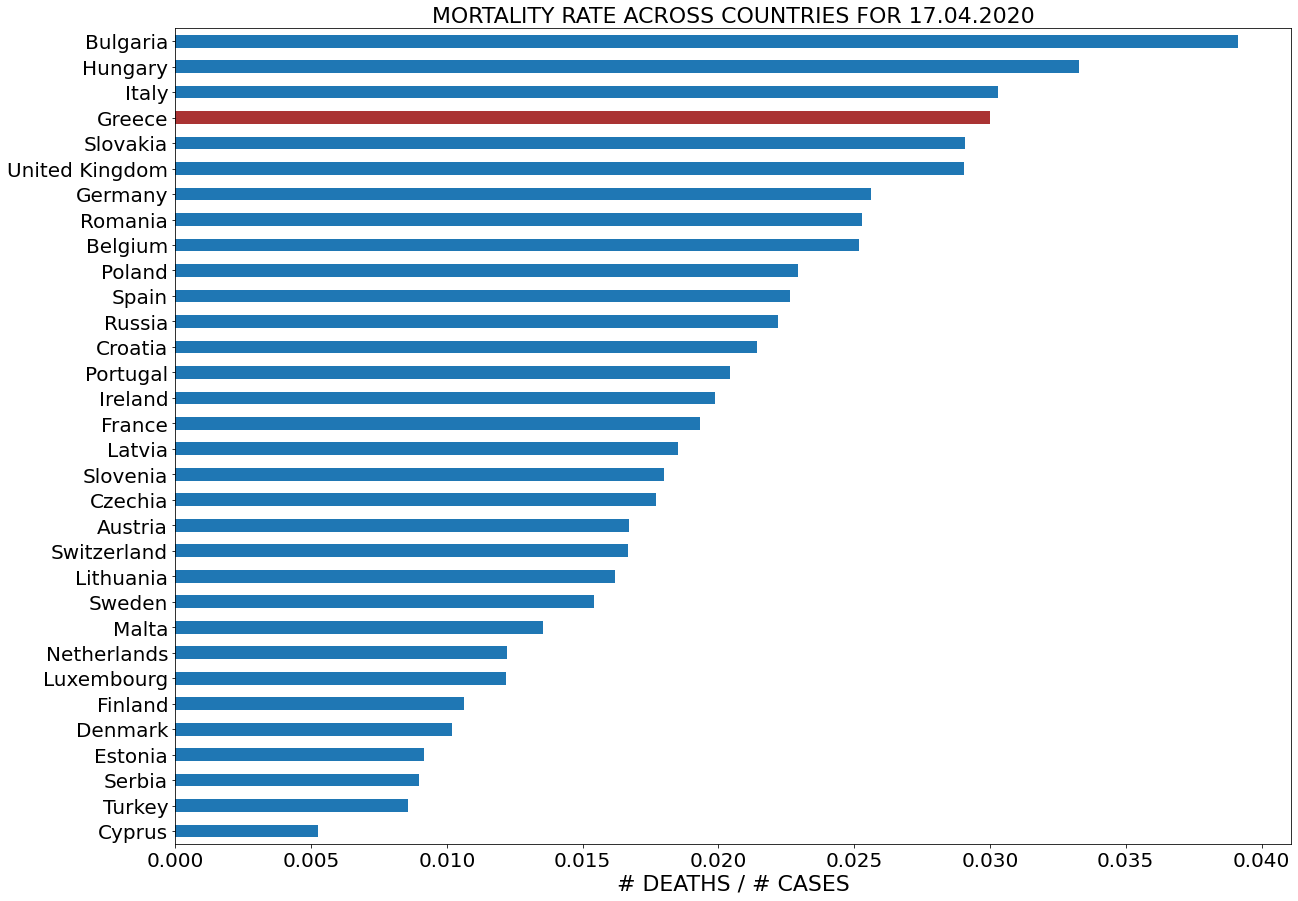

In [66]:
plt.figure(figsize=(20, 15))
ax = mortality_rate_europe.plot.barh(fontsize = 20)
    
highlight = 'Greece'
pos = mortality_rate_europe.index.get_loc(highlight)
ax.patches[pos].set_facecolor('#aa3333')

plt.title('MORTALITY RATE ACROSS COUNTRIES FOR 17.04.2020', fontsize = 22)
plt.xlabel('# DEATHS / # CASES', fontsize = 22)
plt.show()

In [73]:
len(mortality_rate_europe.values), len((mortality_rate_europe.index)), 

(32, 32)

In [74]:
mortality_rate_europe

Cyprus            0.005265
Turkey            0.008572
Serbia            0.008982
Estonia           0.009165
Denmark           0.010194
Finland           0.010642
Luxembourg        0.012177
Netherlands       0.012235
Malta             0.013542
Sweden            0.015420
Lithuania         0.016189
Switzerland       0.016660
Austria           0.016722
Czechia           0.017712
Slovenia          0.018016
Latvia            0.018509
France            0.019307
Ireland           0.019888
Portugal          0.020418
Croatia           0.021412
Russia            0.022211
Spain             0.022635
Poland            0.022940
Belgium           0.025164
Romania           0.025288
Germany           0.025616
United Kingdom    0.029033
Slovakia          0.029089
Greece            0.029999
Italy             0.030301
Hungary           0.033273
Bulgaria          0.039137
Name: 4/15/21, dtype: float64

In [75]:
colors = ['blue',] * len(mortality_rate_europe.values)
colors[18] = 'red'
fig = go.Figure(go.Bar(x=mortality_rate_europe.values,
                       y=mortality_rate_europe.index,
                       marker_color=colors, 
                       orientation='h'))

fig.show()

In [65]:
data  = go.Bar(y = mortality_rate_europe.index,
               x = mortality_rate_europe.values,
               )

layout = go.Layout(title = f"Casos de Covid-19 nas cidades de Santa Catarina ({dia})", 
                  xaxis_title="50 cidades com maior número de casos",
                  yaxis_title='Número de casos')
fig  = go.Figure(data=data, layout=layout)
fig.show()

In [82]:
death_popsize.index

Index(['Finland', 'Cyprus', 'Denmark', 'Turkey', 'Russia', 'Israel', 'Ireland',
       'Estonia', 'Malta', 'Serbia', 'Greece', 'Germany', 'Netherlands',
       'Latvia', 'Austria', 'Switzerland', 'Luxembourg', 'Romania',
       'Lithuania', 'Sweden', 'France', 'Poland', 'Croatia', 'Spain',
       'Portugal', 'United Kingdom', 'Italy', 'Slovenia', 'Slovakia',
       'Belgium', 'Bulgaria', 'Hungary', 'Czechia'],
      dtype='object', name='Country')

In [83]:
colors = ['blue',] * len(death_popsize.index)
colors[24] = 'red'
fig = go.Figure(go.Bar(x=death_popsize.values,
                       y=death_popsize.index,
                       marker_color=colors, 
                       orientation='h'))

fig.show()

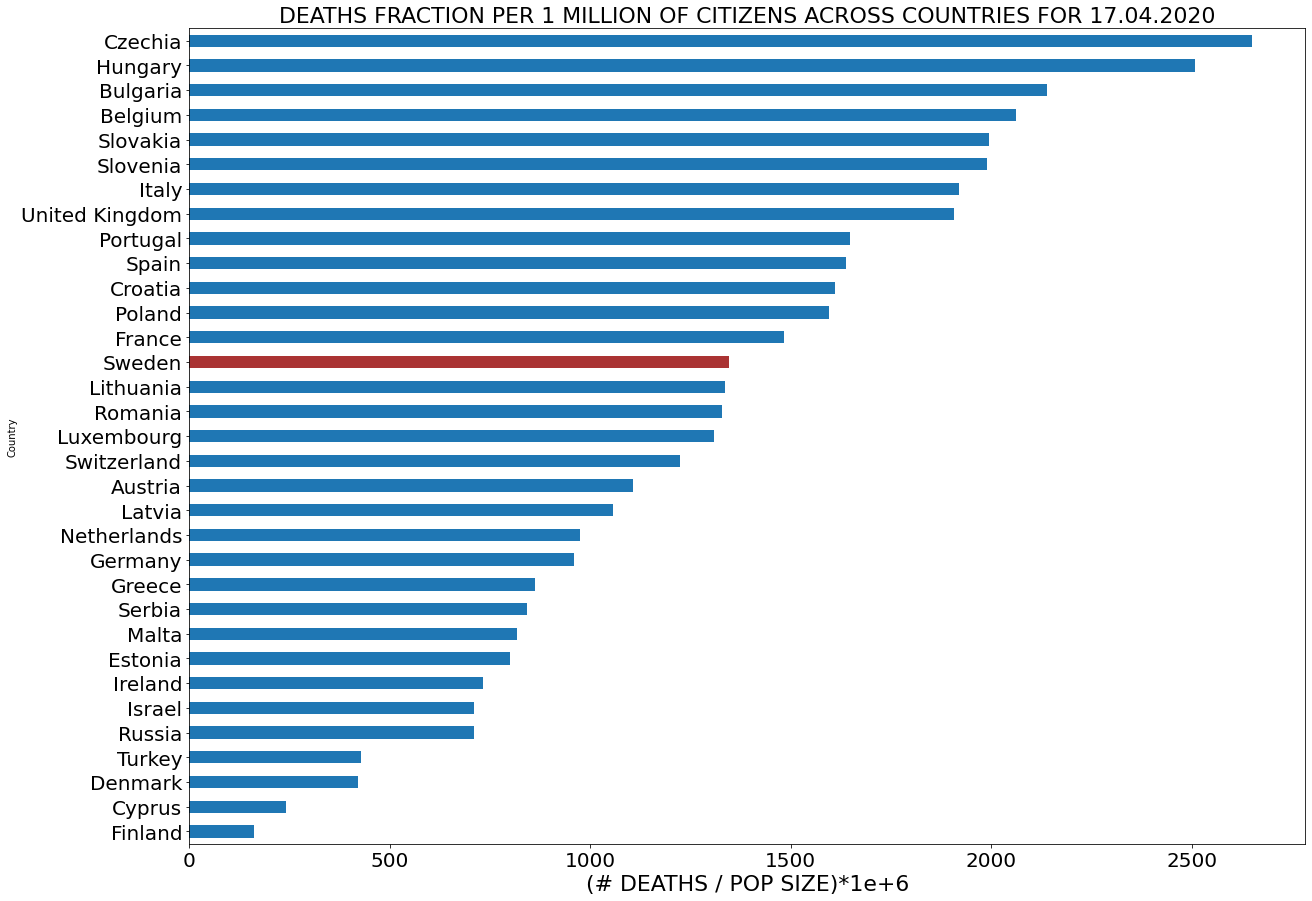

In [76]:
plt.figure(figsize=(20, 15))
ax = death_popsize.plot.barh(fontsize = 20)
    
highlight = 'Sweden'
pos = death_popsize.index.get_loc(highlight)
ax.patches[pos].set_facecolor('#aa3333')

plt.title('DEATHS FRACTION PER 1 MILLION OF CITIZENS ACROSS COUNTRIES FOR 17.04.2020', fontsize = 22)
plt.xlabel('(# DEATHS / POP SIZE)*1e+6', fontsize = 22)
plt.show()

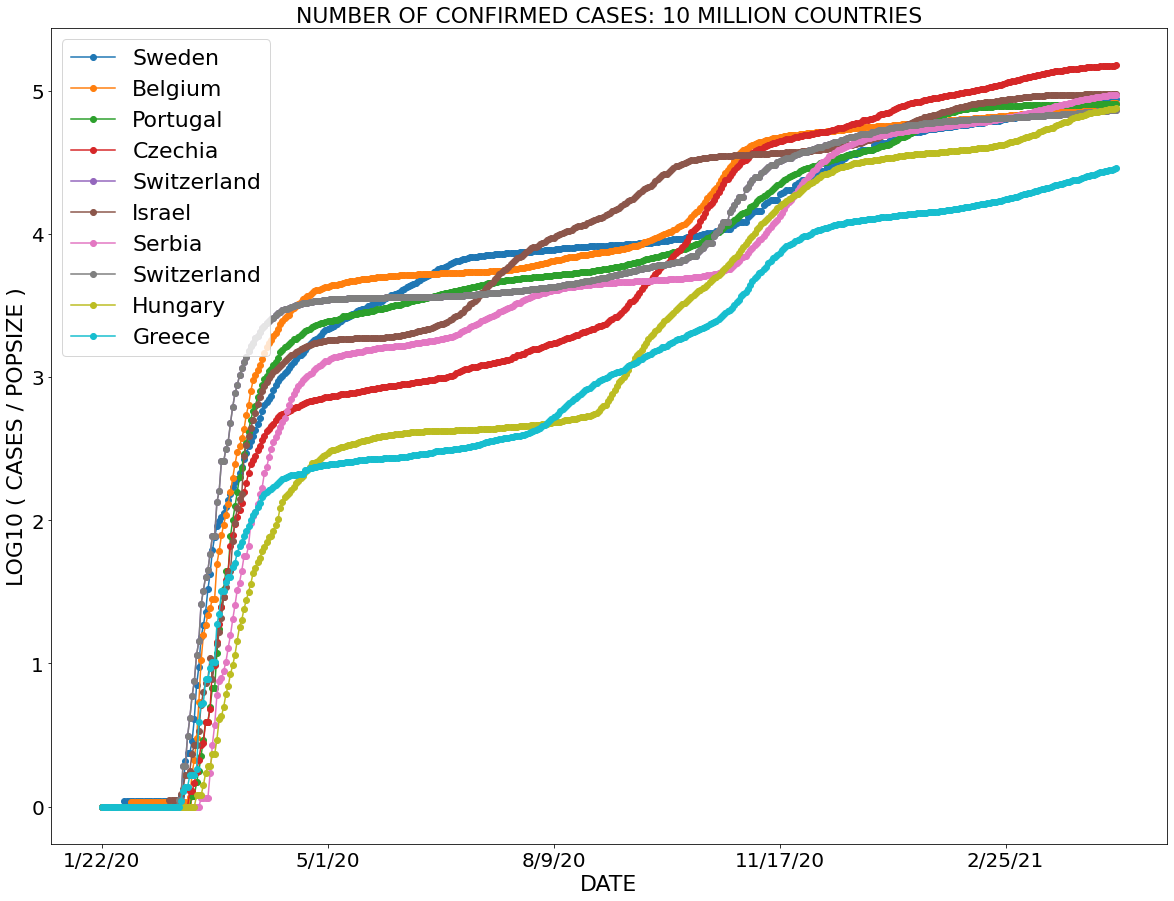

In [85]:
plt.figure(figsize=(20, 15))

#countries_of_interest = ['Sweden', 'Belgium', 'Germany', 'Russia', 'Italy', 'Portugal', 'US']
#countries_of_interest = ['Sweden', 'Belgium', 'Russia', 'Portugal', 'Czechia', 'Israel', 'Hungary', 'Greece']
countries_of_interest = ['Sweden', 'Belgium', 'Portugal', 'Czechia', 'Switzerland', 
                         'Israel', 'Serbia', 'Switzerland', 'Hungary', 'Greece']

for i in countries_of_interest:
    #cases.loc[i].plot(style='o-', fontsize = 20)
    confirmed.loc[i].apply(lambda x: np.log10((x / pop_size_europe_dict[i])*1e+6 + 1)).plot(style='o-', fontsize = 20)

plt.xlabel('DATE', fontsize = 22)
plt.ylabel('LOG10 ( CASES / POPSIZE )', fontsize = 22)
plt.title('NUMBER OF CONFIRMED CASES: 10 MILLION COUNTRIES', fontsize = 22)
plt.legend(countries_of_interest, loc='upper left', fontsize = 22)
plt.show()

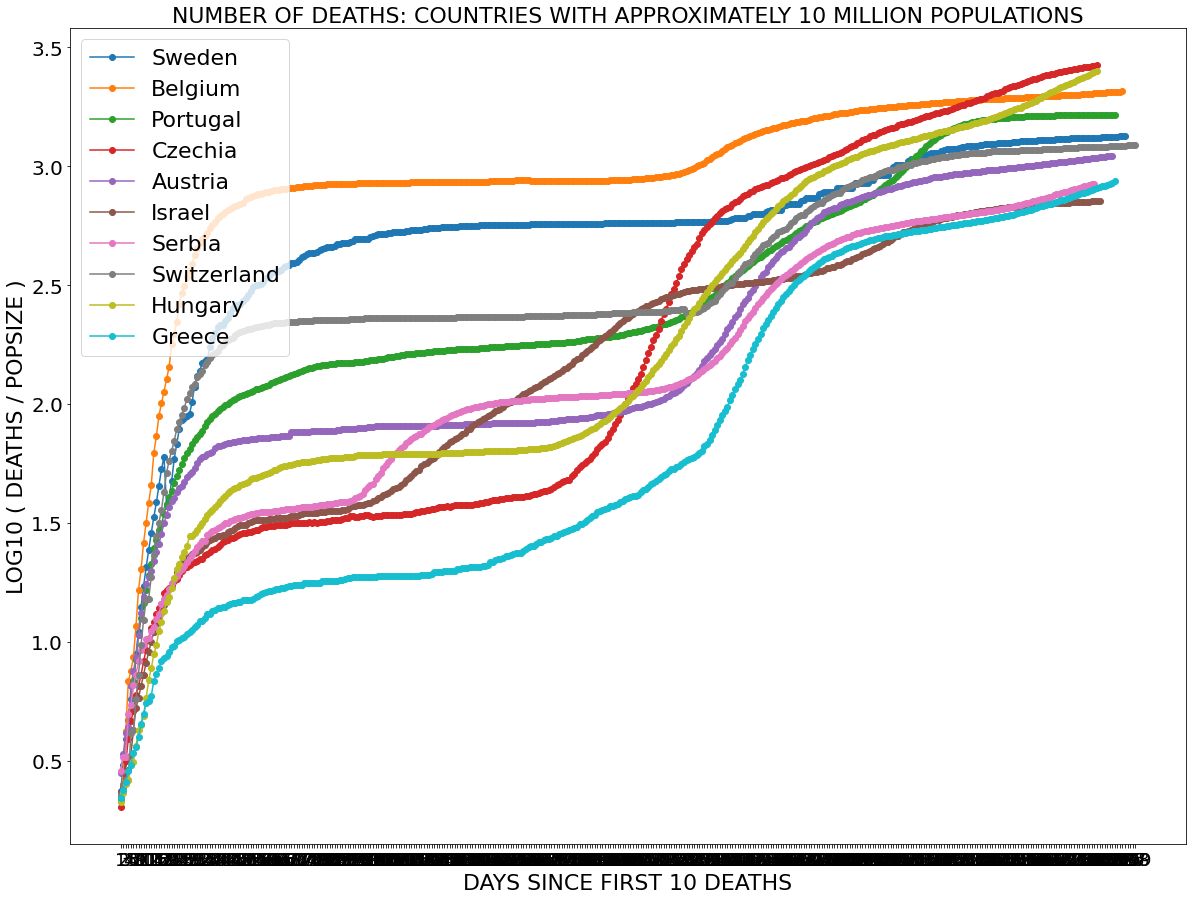

In [86]:
plt.figure(figsize=(20, 15))

countries_of_interest = ['Sweden', 'Belgium', 'Portugal', 'Czechia', 'Austria', 
                         'Israel', 'Serbia', 'Switzerland', 'Hungary', 'Greece']

day_0 = 10
for i in countries_of_interest:
    #deaths.loc[i].plot(style='o-', fontsize = 20)
    deaths.loc[i][deaths.loc[i]>day_0].apply(lambda x:
                                         np.log10((x/pop_size_europe_dict[i])*1e+6+1)).plot(style='o-',
                                                                                            fontsize=20)

plt.xlabel('DAYS SINCE FIRST 10 DEATHS', fontsize = 22)
plt.ylabel('LOG10 ( DEATHS / POPSIZE )', fontsize = 22)
plt.title('NUMBER OF DEATHS: COUNTRIES WITH APPROXIMATELY 10 MILLION POPULATIONS', fontsize = 22)
plt.legend(countries_of_interest, loc='upper left', fontsize = 22)
my_ticks = np.array(list(range(len(list(deaths.loc['Switzerland'][deaths.loc['Switzerland']>day_0])))))
plt.xticks(ticks = my_ticks, labels = my_ticks+1, fontsize = 18)
plt.show()

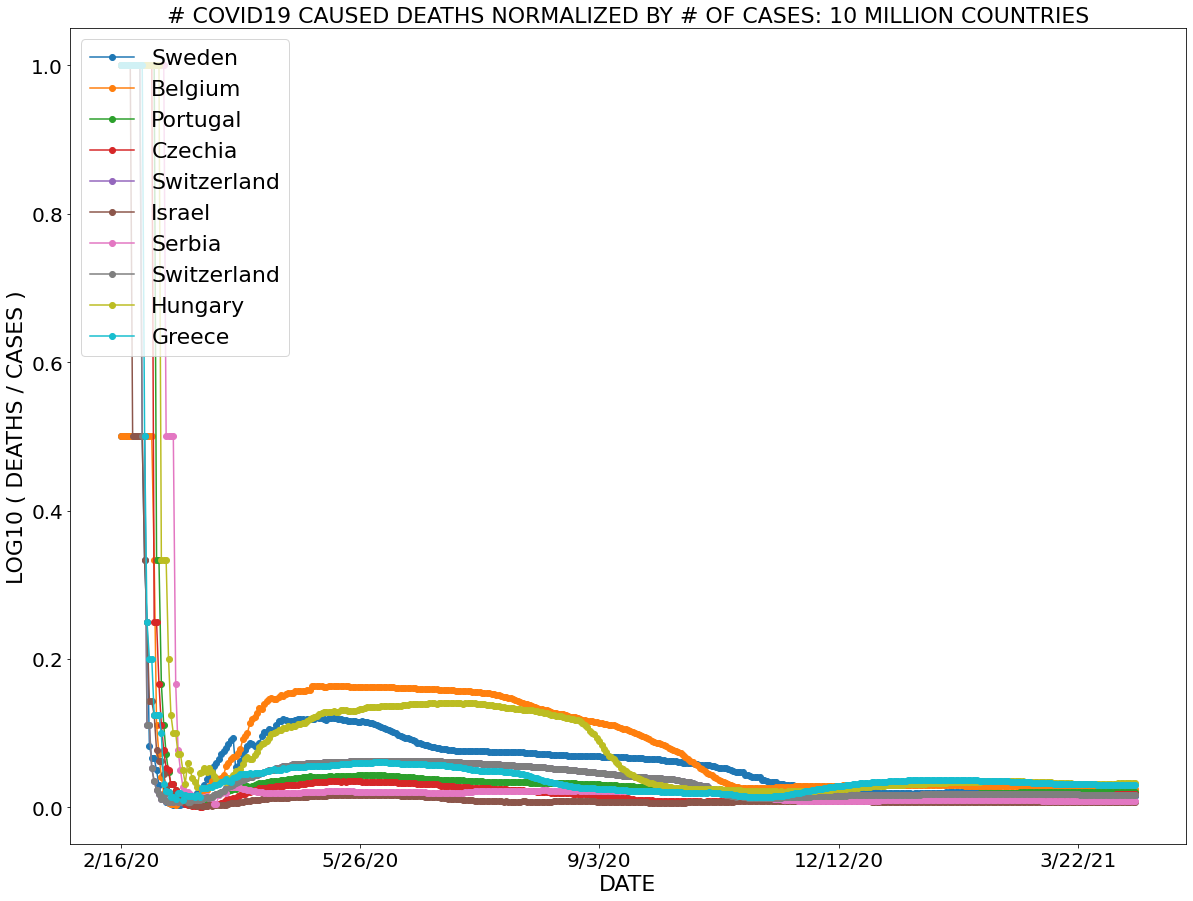

In [87]:
plt.figure(figsize=(20, 15))

countries_of_interest = ['Sweden', 'Belgium', 'Portugal', 'Czechia', 'Switzerland', 
                         'Israel', 'Serbia', 'Switzerland', 'Hungary', 'Greece']

for i in countries_of_interest:
    deaths2cases.loc[i].plot(style='o-', fontsize = 20)

plt.xlabel('DATE', fontsize = 22)
plt.ylabel('LOG10 ( DEATHS / CASES )', fontsize = 22)
plt.title('# COVID19 CAUSED DEATHS NORMALIZED BY # OF CASES: 10 MILLION COUNTRIES', fontsize = 22)
plt.legend(countries_of_interest, loc='upper left', fontsize = 22)
plt.show()

In [106]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, RBF, ExpSineSquared, DotProduct

#kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
kernel = DotProduct() * RBF()
gp = gaussian_process.GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 9, alpha = 0.007)
gp.fit(days, sweden_deaths)

GaussianProcessRegressor(alpha=0.007,
                         kernel=DotProduct(sigma_0=1) * RBF(length_scale=1),
                         n_restarts_optimizer=9)

In [88]:
sweden_deaths = np.array(list(deaths.loc['Sweden'])).reshape(-1,1)
sweden_deaths = sweden_deaths[sweden_deaths != 0]
days = np.array(list(range(len(sweden_deaths)))).reshape(-1,1)
days.shape

(402, 1)

In [90]:
days_pred = np.linspace(0, 100, num = 100).reshape(-1,1)
deaths_pred, sigma = gp.predict(days_pred, return_std=True)

In [91]:
deaths_pred

array([9.99999681e-01, 1.04217533e+00, 1.98129844e+00, 3.08105307e+00,
       5.05874478e+00, 7.09274306e+00, 8.12589275e+00, 1.46166468e+01,
       2.14948535e+01, 3.09824850e+01, 3.86742850e+01, 5.05582740e+01,
       6.13966132e+01, 8.47338023e+01, 1.05608923e+02, 1.40479157e+02,
       1.69409717e+02, 2.09745619e+02, 2.43447658e+02, 2.97287426e+02,
       3.36430244e+02, 4.05832976e+02, 4.61181677e+02, 5.73143464e+02,
       5.60497681e+02, 3.46077808e+02, 4.31504258e+02, 4.96050056e+02,
       6.28727486e+02, 7.08821183e+02, 8.29900907e+02, 8.73262063e+02,
       8.96050887e+02, 8.96808700e+02, 9.49573294e+02, 1.08831307e+03,
       1.26337653e+03, 1.35546306e+03, 1.44244971e+03, 1.53505880e+03,
       1.54173333e+03, 1.64209702e+03, 1.85337883e+03, 1.97333141e+03,
       2.07696852e+03, 2.18826231e+03, 2.18388363e+03, 2.22664217e+03,
       2.31479649e+03, 2.40102605e+03, 2.52919092e+03, 2.62763246e+03,
       2.66766848e+03, 2.66663686e+03, 2.72166412e+03, 2.81996474e+03,
      

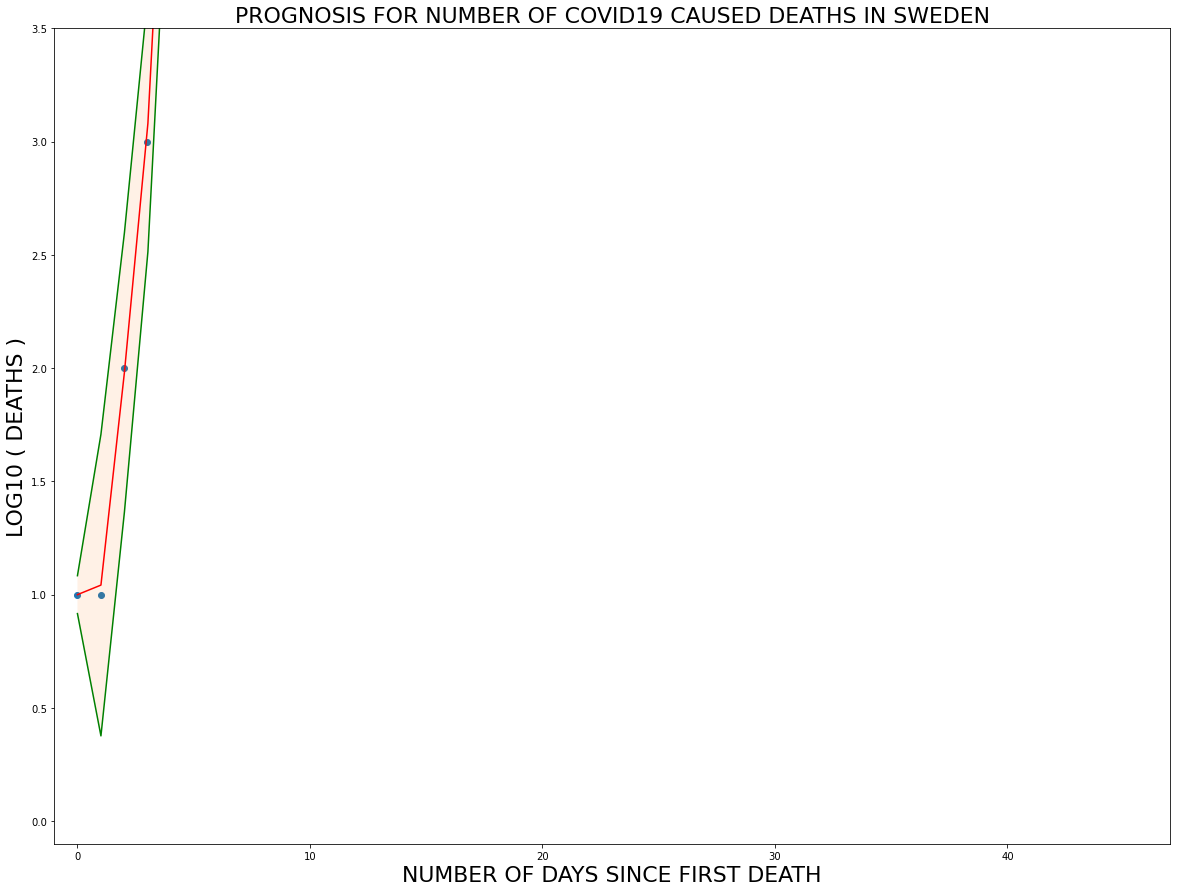

In [92]:
plt.figure(figsize=(20, 15))

plt.scatter(days, sweden_deaths)
plt.plot(days_pred, deaths_pred, c='r')
plt.plot(days_pred, deaths_pred + sigma, c='g')
plt.plot(days_pred, deaths_pred - sigma, c='g')
plt.fill_between(days_pred.flatten(), deaths_pred + sigma, deaths_pred - sigma, alpha=0.1)
plt.xlim([-1,47]); plt.ylim([-0.1,3.5])
plt.xlabel('NUMBER OF DAYS SINCE FIRST DEATH', fontsize = 22)
plt.ylabel('LOG10 ( DEATHS )', fontsize = 22)
plt.title('PROGNOSIS FOR NUMBER OF COVID19 CAUSED DEATHS IN SWEDEN', fontsize = 22)
plt.show()